In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pickle
from datetime import datetime, timedelta

import sqlalchemy as sa

In [2]:
# load data from yesterday (getdate() - 1) LOCH
connstr = 'redshift+psycopg2:// *** proper credential required ***'
engine = sa.create_engine(connstr, connect_args={'sslmode': 'verify-ca'})

In [3]:
with engine.connect() as conn, conn.begin():
    df = pd.read_sql(sa.text("""
    SELECT
    call_data_ordinals.contact_id  AS "contact_id",
    CONVERT_TIMEZONE('UTC', 'America/Chicago', call_data_ordinals.contact_created_at ) AS "datetime_contact",
    call_data_ordinals.valid_lead  AS "valid_lead",
    call_data_ordinals.ew_gw AS "ew_gw",
    call_data_ordinals.tag_name  AS "tag_name",
	call_data_ordinals.lead_source  AS "lead_source",
    call_data_ordinals.call_id  AS "call_id",
    	call_data_ordinals.provider  AS "provider",
	DATE(CONVERT_TIMEZONE('UTC', 'America/Chicago', call_data_ordinals.call_created_at )) AS "date_call",
	CONVERT_TIMEZONE('UTC', 'America/Chicago', call_data_ordinals.call_created_at ) AS "datetime_call",	
	CASE WHEN call_data_ordinals.call_type = 1 THEN 'Inbound' ELSE 'Outbound' END  AS "call_type",
    CASE WHEN call_data_ordinals.call_result = 2 THEN 'Answered'
                WHEN call_data_ordinals.call_result = 3 THEN 'Hangup'
                WHEN call_data_ordinals.call_result = 4 THEN 'Voicemail'
                WHEN call_data_ordinals.call_result = 5 THEN 'Voicemail Drop'
                WHEN call_data_ordinals.call_result = 6 THEN 'Short Call'
                ELSE 'Unknown' END AS "call_result",
    CASE WHEN call_data_ordinals.contact_id IS NOT NULL THEN call_data_ordinals.attempt_ordinal ELSE NULL END  AS "attempt_ordinal",
    call_data_ordinals.cc90 AS "cc90",
	call_data_ordinals.talk_duration  AS "talk_duration_secs",	
	CASE WHEN call_data_ordinals.contact_id IS NOT NULL THEN call_data_ordinals.client_closed_this_call ELSE NULL END AS "client_closed_this_call",
	CASE WHEN call_data_ordinals.contact_id IS NOT NULL THEN call_data_ordinals.client_closed_ever ELSE NULL END  AS "client_closed"
FROM looker_scratch.LR$J7D16NPQR73MIJ7D7KKJH_call_data_ordinals AS call_data_ordinals

WHERE (call_data_ordinals.call_created_at >= 2018-01-01) 
AND (call_data_ordinals.tenant_name <> 'Veritas Prep' OR call_data_ordinals.tenant_name IS NULL) 
AND (CASE WHEN call_data_ordinals.contact_id IS NOT NULL THEN call_data_ordinals.attempt_ordinal ELSE NULL END  = 1) 
AND ((call_data_ordinals.tag_name  NOT IN ('music', 'international', 'prof certifications', 'international ROW', 'VP-Main', 'VP-AdCon', 'VP-International', 'Free SAT/ACT') OR call_data_ordinals.tag_name IS NULL))
ORDER BY 1 DESC

"""), conn)

In [4]:
df_master = df.copy()

In [70]:
df = df_master.copy()
df.date_call = pd.to_datetime(df.date_call)
df['datetime_call_sanitised'] = np.where(df.provider == 'genesys' , df.datetime_call - pd.to_timedelta(df.talk_duration_secs, unit='seconds') ,  df.datetime_call)
df['time_mins_first_call'] = (df.datetime_call_sanitised - df.datetime_contact).astype('timedelta64[m]')

In [71]:
df.head()

,contact_id,datetime_contact,valid_lead,ew_gw,tag_name,lead_source,call_id,provider,date_call,datetime_call,call_type,call_result,attempt_ordinal,cc90,talk_duration_secs,client_closed_this_call,client_closed,datetime_call_sanitised,time_mins_first_call
0,2709589,2019-10-31 11:58:04,1,GW,core,Unknown,21946776,genesys,2019-10-31,2019-10-31 12:00:02,Inbound,Short Call,1,0,4.0,0,0,2019-10-31 11:59:58,1.0
1,2709586,2019-10-31 11:56:52,1,GW,core,Unknown,21946695,genesys,2019-10-31,2019-10-31 11:58:34,Outbound,Short Call,1,0,2.0,0,0,2019-10-31 11:58:32,1.0
2,2709584,2019-10-31 11:55:58,1,GW,GW main,Unknown,21946727,genesys,2019-10-31,2019-10-31 11:59:07,Outbound,Short Call,1,0,38.0,0,0,2019-10-31 11:58:29,2.0
3,2709578,2019-10-31 11:52:49,1,GW,GW main,Unknown,21946537,genesys,2019-10-31,2019-10-31 11:55:12,Outbound,Short Call,1,0,24.0,0,0,2019-10-31 11:54:48,1.0
4,2709574,2019-10-31 11:51:13,1,GW,GW main,Unknown,21946775,genesys,2019-10-31,2019-10-31 12:00:00,Inbound,Answered,1,1,374.0,0,0,2019-10-31 11:53:46,2.0


In [72]:
#creating dataframes for each of twilio, GPC (normalized) and all others

lead_source_exclude = ['Phone - Organic', 'Phone - Paid', 'Phone']

df_analysis_twilio = pd.pivot_table(df[(df.time_mins_first_call>=0) & (df.call_type == 'Outbound') 
                                & (df.provider == 'twilio') & (df.valid_lead == 1) & (~df.lead_source.isin(lead_source_exclude))]
                             ,index = 'time_mins_first_call'
                             ,values = ['call_id' , 'cc90' , 'client_closed_this_call', 'client_closed']
                             ,aggfunc = {'call_id': lambda x: x.nunique() 
                                         ,'cc90':np.sum
                                         ,'client_closed_this_call':np.sum
                                         ,'client_closed':np.sum
                                        }
                            )

df_analysis_gpc = pd.pivot_table(df[(df.time_mins_first_call>=0) & (df.call_type == 'Outbound') 
                                & (df.provider == 'genesys') & (df.valid_lead == 1)]
                             ,index = 'time_mins_first_call'
                             ,values = ['call_id' , 'cc90' , 'client_closed_this_call', 'client_closed']
                             ,aggfunc = {'call_id': lambda x: x.nunique() 
                                         ,'cc90':np.sum
                                         ,'client_closed_this_call':np.sum
                                         ,'client_closed':np.sum
                                        }
                            )

df_analysis = pd.pivot_table(df[(df.time_mins_first_call>=0) & (df.call_type == 'Outbound') & (df.valid_lead == 1)]
                             ,index = 'time_mins_first_call'
                             ,values = ['call_id' , 'cc90' , 'client_closed_this_call', 'client_closed']
                             ,aggfunc = {'call_id': lambda x: x.nunique() 
                                         ,'cc90':np.sum
                                         ,'client_closed_this_call':np.sum
                                         ,'client_closed':np.sum
                                        }
                            )

In [74]:
#creating analysis metrics

df_analysis_twilio.columns = ['total_leads','total_cc90s', 'total_closed_ever' , 'total_occ']
df_analysis_gpc.columns = ['total_leads','total_cc90s', 'total_closed_ever' , 'total_occ']
df_analysis.columns = ['total_leads','total_cc90s', 'total_closed_ever' , 'total_occ']

df_analysis['cc90_rate'] = df_analysis.total_cc90s/df_analysis.total_leads
df_analysis_twilio['cc90_rate'] = df_analysis_twilio.total_cc90s/df_analysis_twilio.total_leads
df_analysis_gpc['cc90_rate'] = df_analysis_gpc.total_cc90s/df_analysis_gpc.total_leads

df_analysis['SCVR'] = df_analysis.total_closed_ever/df_analysis.total_leads
df_analysis_twilio['SCVR'] = df_analysis_twilio.total_closed_ever/df_analysis_twilio.total_leads
df_analysis_gpc['SCVR'] = df_analysis_gpc.total_closed_ever/df_analysis_gpc.total_leads

df_analysis['OCC_rate'] = df_analysis.total_occ/df_analysis.total_leads
df_analysis_twilio['OCC_rate'] = df_analysis_twilio.total_occ/df_analysis_twilio.total_leads
df_analysis_gpc['OCC_rate'] = df_analysis_gpc.total_occ/df_analysis_gpc.total_leads

df_analysis_twilio['rolling_3min_avg_CC90rate'] = df_analysis_twilio.total_cc90s.rolling(3).sum() / df_analysis_twilio.total_leads.rolling(3).sum()
df_analysis_gpc['rolling_3min_avg_CC90rate'] = df_analysis_gpc.total_cc90s.rolling(3).sum() / df_analysis_gpc.total_leads.rolling(3).sum()
df_analysis['rolling_3min_avg_CC90rate'] = df_analysis.total_cc90s.rolling(3).sum() / df_analysis.total_leads.rolling(3).sum()

df_analysis_twilio['rolling_3min_avg_SCVR'] = df_analysis_twilio.total_closed_ever.rolling(3).sum() / df_analysis_twilio.total_leads.rolling(3).sum()
df_analysis_gpc['rolling_3min_avg_SCVR'] = df_analysis_gpc.total_closed_ever.rolling(3).sum() / df_analysis_gpc.total_leads.rolling(3).sum()
df_analysis['rolling_3min_avg_SCVR'] = df_analysis.total_closed_ever.rolling(3).sum() / df_analysis.total_leads.rolling(3).sum()

df_analysis_twilio['rolling_3min_avg_OCC'] = df_analysis_twilio.total_occ.rolling(3).sum() / df_analysis_twilio.total_leads.rolling(3).sum()
df_analysis_gpc['rolling_3min_avg_OCC'] = df_analysis_gpc.total_occ.rolling(3).sum() / df_analysis_gpc.total_leads.rolling(3).sum()
df_analysis['rolling_3min_avg_OCC'] = df_analysis.total_occ.rolling(3).sum() / df_analysis.total_leads.rolling(3).sum()


In [75]:
df_analysis.head()

,total_leads,total_cc90s,total_closed_ever,total_occ,cc90_rate,SCVR,OCC_rate,rolling_3min_avg_CC90rate,rolling_3min_avg_SCVR,rolling_3min_avg_OCC
time_mins_first_call,,,,,,,,,,
0.0,59504,24677,6008,1228,0.414712,0.100968,0.020637,NaN,NaN,NaN
1.0,72338,27993,6713,1331,0.386975,0.092800,0.018400,NaN,NaN,NaN
2.0,61101,22621,5867,1161,0.370223,0.096021,0.019001,0.390224,0.096339,0.019280
3.0,51294,18531,4798,916,0.361270,0.093539,0.017858,0.374297,0.094071,0.018448
4.0,47304,16571,4297,817,0.350309,0.090838,0.017271,0.361449,0.093689,0.018122


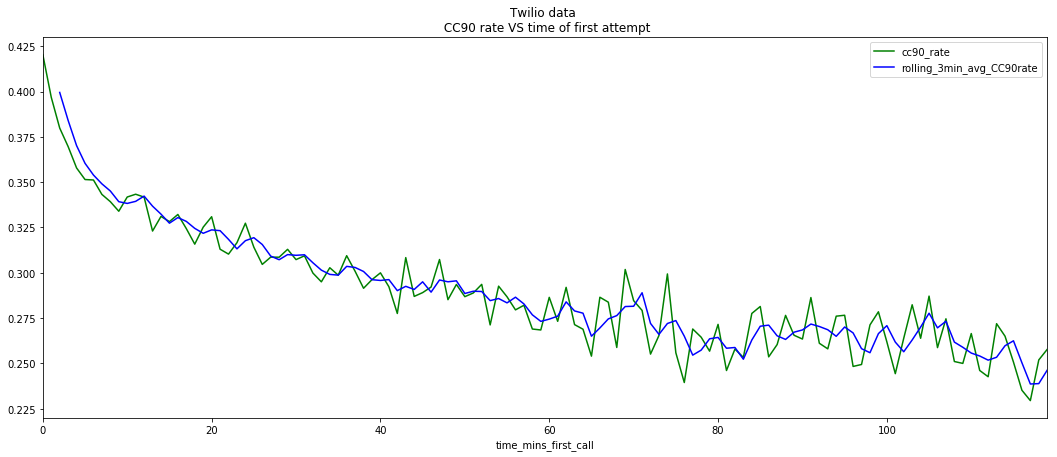

In [85]:
df_analysis_twilio[df_analysis_twilio.index<120][['cc90_rate' , 'rolling_3min_avg_CC90rate']].plot(kind='line' , color = ('g','b'), figsize = (18,7) , title = 'Twilio data \n CC90 rate VS time of first attempt')

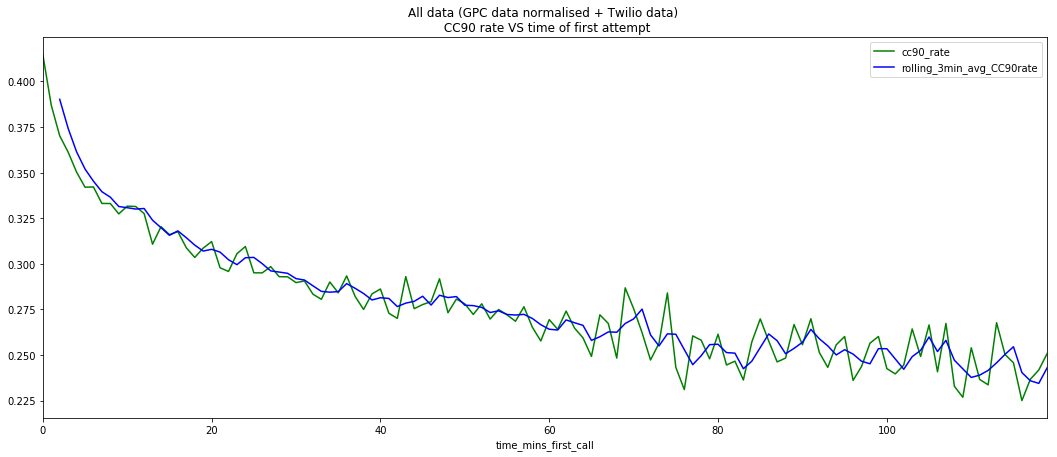

In [86]:
df_analysis[df_analysis.index<120][['cc90_rate' , 'rolling_3min_avg_CC90rate']].plot(kind='line' , color = ('g','b'),figsize = (18,7) , title = 'All data (GPC data normalised + Twilio data) \n CC90 rate VS time of first attempt')

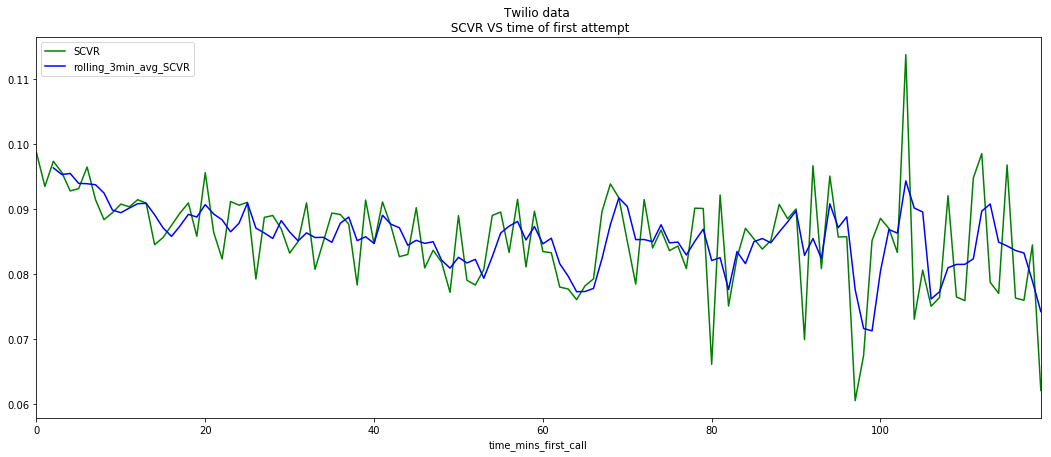

In [87]:
df_analysis_twilio[df_analysis_twilio.index<120][['SCVR' , 'rolling_3min_avg_SCVR']].plot(kind='line' , color = ('g','b'), figsize = (18,7) , title = 'Twilio data \n SCVR VS time of first attempt')

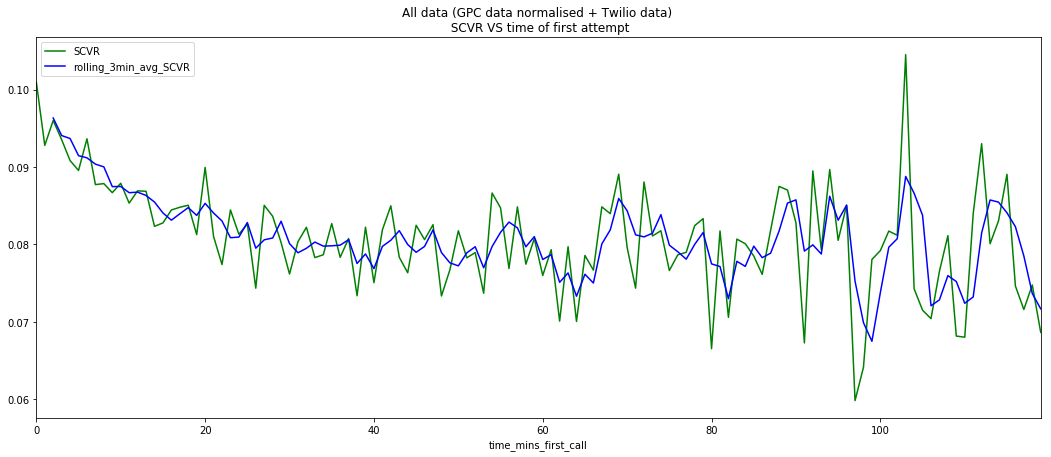

In [88]:
df_analysis[df_analysis.index<120][['SCVR' , 'rolling_3min_avg_SCVR']].plot(kind='line' , color = ('g','b'), figsize = (18,7) , title = 'All data (GPC data normalised + Twilio data) \n SCVR VS time of first attempt')

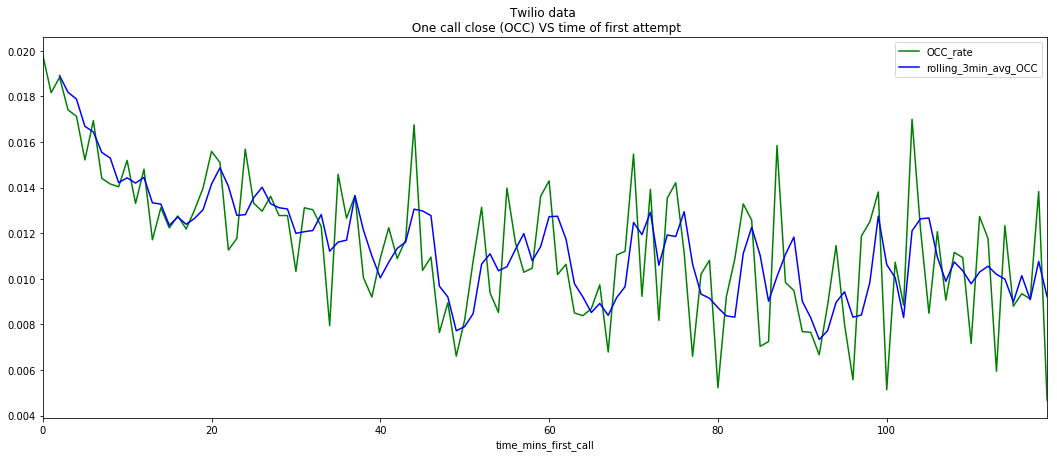

In [89]:
df_analysis_twilio[df_analysis_twilio.index<120][['OCC_rate' , 'rolling_3min_avg_OCC']].plot(kind='line' , color = ('g','b'), figsize = (18,7) , title = 'Twilio data \n One call close (OCC) VS time of first attempt')

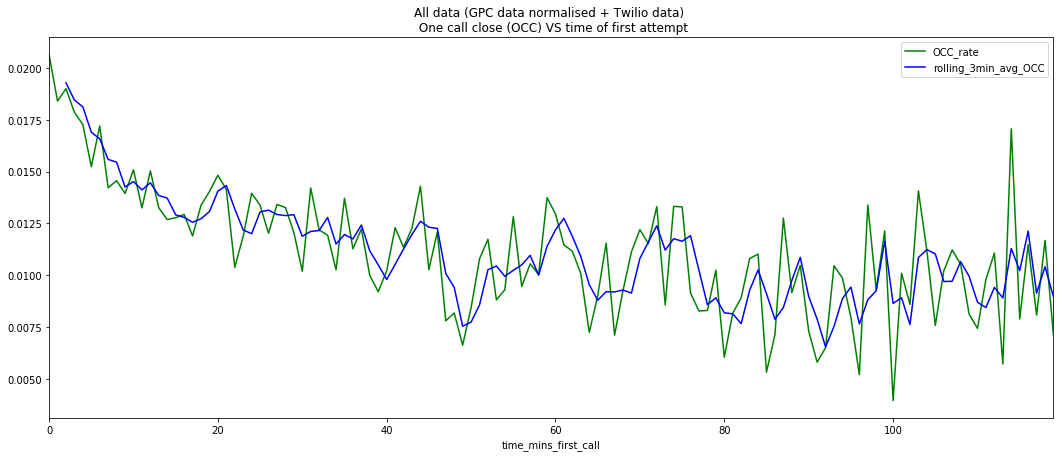

In [90]:
df_analysis[df_analysis.index<120][['OCC_rate' , 'rolling_3min_avg_OCC']].plot(kind='line' , color = ('g','b'), figsize = (18,7) , title = 'All data (GPC data normalised + Twilio data) \n One call close (OCC) VS time of first attempt')